#1. Summary

In this project, we will use (s,S) policy to slove the inventory problem and compute the optimal strategy to appropriate allocate inventory level. (s,S) policy is a minimum/maximum inventory policy, which s* represents the optimal order-up-to level and S* represents the optimal reorder level. Under (s,S) policy, an order is placed to increase the item’s inventory position to the level S as soon as this inventory position reaches or drops below the level s.

We made 5 steps to derive the optimalization. First, we will derive the Markov Decision Process (MDP) for the scenario of problem given, with the demand of uniform distribution between 0 to 10. The demand is random variable here in our problem, and other variables are given in specific numbers. By computing all given information, we got the MDP in first part which is the base for further investigation. Then we used two different method, policy iteration and Q learning to deal with the inventory optimality. The policy iteration gives us the feasible solutions happened in state ranging from 0 to 13, and the optimal result is (13,70). For Q learning, the optimal policy is (6,74). In this part, we also considered the condition that there is no demands in weekend and transformed data from weekly to daily form in order to simulate Q learning under this circumstance. Further illustration will be found in later section. In the end, we visualized all results from two methods and made some comparison.




#2. MDP Formulation

MDP is the foundation of reinforcement learning. Most reinforcement learning problems can be transformed into MDP problems. In the reinforement learning, an agent is supposed to decide the best action to select based on his current state. When this step is repeated, the problem is known as a Markov Decision Process. 


A Markov Decision Process (MDP) model contains: 

1. A set of possible world states S.
2. A set of Models.
3. A set of possible actions A.
4. A real-valued reward function R(s,a).
5.  policy the solution of Markov Decision Process.

**Notation：**
In our inventor problem, we set notations for MDP.

1. State Space ——— St：the current inventory level at time t, range from[0,100]

  St+1: future inventory level at time t+1, range from[0,100]

2. Actions ——— a: ordering quantity at time t, will arrive in t+1, range from[0,100]

3. Reward Function ——— R(s,a)

4. Demand ——— d: a  random variable which follows the uniform distribution UNIF(0,10), range from[0,10]

5. Stockout = St-d (we use d-st to eliminate the minus sign for more convenient calculation)

6. Max demand = 10
7. Max inventory = 100
8. Lead time: 1 week

In [ ]:
import numpy as np
import pandas as pd
import time 
import matplotlib.pyplot as plt

In [ ]:
#weekly demand follows UNIF(0,10) ditribution
a=1/11
d = {'demand': [0,1,2,3,4,5,6,7,8,9,10], 'prob': [a,a,a,a,a,a,a,a,a,a,a]}
df = pd.DataFrame(data=d)
df['ev']=df['demand']*df['prob'] #expected value
df

,demand,prob,ev
0,0,0.090909,0.000000
1,1,0.090909,0.090909
2,2,0.090909,0.181818
3,3,0.090909,0.272727
4,4,0.090909,0.363636
5,5,0.090909,0.454545
6,6,0.090909,0.545455
7,7,0.090909,0.636364
8,8,0.090909,0.727273
9,9,0.090909,0.818182


Following we defined parameters given in the problem

In [ ]:
#parameters
price =10
c=4
h=2/52
k=100
penalty=15
max_inv=100
tao=1 #lead time is 1 week

Revenue function:

In [ ]:
#Revenue function R(u)
def rev(u):
  if u <=10:
    quant = sum(df['ev'][:u]) + sum(df['prob'][u+1:])*u
    revenue = price*quant
  else:
    revenue = price*sum(df['ev'][:])
  return revenue

In [ ]:
rev(90)

50.0

Reward function:

The reward function equals to revenue minus all other cost. In the problem, we have 3 kinds of cost, setup cost, holding cost and stockout penalty cost.

To compute the reward function, we considered two cases:
1. when there is no ordering quantity(a=0), which means no cost, the reward function will only depend on penalty cost or holding cost or both;
2. when there exists set up cost(a>0), we should consider three kinds of costs. 

In each case, we divided the condition into with stockout and without stockout as sub cases to calculate th reward function. Therefore, we have total 5 cased to discuss in the following code.

Note：Because we have a lead time of 1 week, everytime when we have ordering quantity of "a", we have not received it yet. The amount of goods "a" will be delivered in the next week. Therefore, we do not have carrying cost which means holding cost for this quantity "a". 

In [ ]:
#Reward function r(s,a)

def r(s,a):
  stockout = 0 
  u=s+a
  if u>100:
    reward = -1000000

  #when there is no ordering quantity, which means no setup cost
  if a == 0:
    #only penalty cost
    if s==0:
      for i in range(s+1,11):
        out = i-s
        stockout = out*df['prob'][i] + stockout
      reward = (-1)*penalty*stockout
    #only hoding cost (no stockout)
    elif s>=10:
      reward = rev(s)-(h*s)
    #both holding cost and penalty cost
    else: 
      for i in range(s+1,11):
        out = i-s
        stockout = out*df['prob'][i] +stockout
      reward = rev(s)-(h*s)-(penalty*stockout)
  

  #when there is setup cost
  if a >0:
    #only hoding and setup cost (no stockout)
    if s>=10:
      reward = rev(s)-(k+c*a)-(h*s)
    #three costs all exist
    else:
      for i in range(s+1,11):
        out = i-s
        stockout = out*df['prob'][i] +stockout
      reward = rev(s)-(k+c*a)-(h*s)-(penalty*stockout)

  return reward 
  

In [ ]:
r(80,30)

-173.07692307692307

Transition Probabilities:

When we look up the transition probabilities, we noticed that there are total 4 kinds of values in transition probability matrix:

1. p = 1

  This case only happens at the beginning when everything is zero.
2. p = 0

  This is the case where all imposible cases calculated.
3. p = sum of several probabilities

  In the case, we have stockout at the moment, therefore our demand could be many cases which lead us to stockout. Then the p value should be a sum of several probabilities.
4. p = a single probability

  In this case, we do not stockout, by calculating demand = St + a - St+1, the possibile demand is unique. Then the p value should be a single probability.

In following code, we denote t(St) as current inventory level, t1(St+1) as future inventory level at time t+1, and a as ordering quantity.

In [ ]:
#Transition Probabilities
max_demand = 10
def pp(t, t1, a):
  if t == t1 == a == 0:
    p = 1
  elif t1 > t + a or t + a - max_demand > t1:
    p = 0
  elif (t + a < max_demand) and (t1 == 0):
    p = sum(df['prob'][t + a:])
  else:
    d = t + a - t1 
    p = df['prob'][d]
  return p

In [ ]:
pp(7,0,1)

0.2727272727272727

#3. Methods

##a. Policy Iteration:

Policy iteration is one of the algorithms in "reinforcement learning". This technique is useful when there are multiple options to choose, each with its own risks and rewards. The following section specifies the policy iteration algorithm can be applied to solve Markov decision processes.

Here is a shortened description of each step in policy iteration:
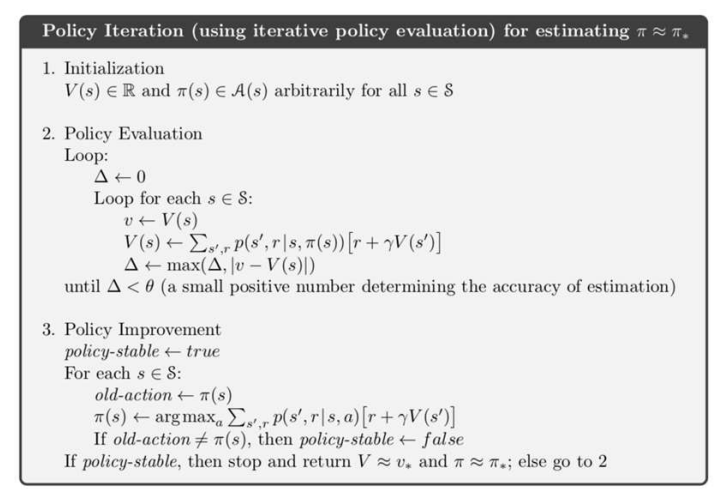

At the beginning, we do not care whether the initial policy $π_0$ is optimal or not. We focus on improving it by repeating the policy evaluation and policy improvement steps in each iteration. Policy evaluation is to evaluate the policy by a specific computational function that keeps the value function the same as the current policy. Policy improvement is to improve a better policy based on the previously obtained values. When we use this algorithm, we generate a series of policies and each policy is an improvement of the previous one. We perform policy evaluation and policy improvement steps until the policy is no longer improved.

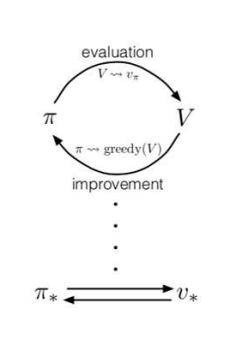

When we apply policy iteration, we need to satisfy the following requirements which are "state" and "action" are discrete values. Policy iteration is a method for finding the optimal policy for a given state and action. When the policy does not change throughout the iteration, then convergence is achieved and there are the best values of s and a.

The policy iterations are compared with the value iterations when they are both dynamic programming algorithms that find the optimal policy $π_*$ in the reinforcement learning. They both use a variant of Bellman update and utilize one-step look-ahead. But the difference is that the policy iteration algorithm updates the policy, while the value iteration algorithm iterates over the value function instead. In addition, in each iteration the policy iteration function goes through two phases, policy evaluation and policy improvement. The value iteration function covers these two phases by taking the maximum value of the utility function for all possible actions. Although both algorithms can eventually converge to the optimal policy, the policy iteration algorithm converges in fewer iterations.

Since reinforcement machine learning algorithms are not suitable for solving simple problems and require a lot of data and computation, policy iteration also has drawbacks. For example, each iteration of policy iteration involves policy evaluation, which can be a lengthy computational process that requires multiple sweeps through the state set.


##b. Q-Learning:

Q-learning is an model-free, off-policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy, like taking random actions, and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward.  The ‘q’ in q-learning stands for quality, which represents how useful a given action is in gaining some future reward.

When q-learning is performed, we create what’s called a q-table or matrix that follows the shape of (state s, action a) and we initialize our values to zero. We then update and store our q-values after an episode. This q-table becomes a reference table for our agent to select the best action based on the q-value.

There are two ways for an agent to interact with the environment and make updates to the state action pairs in q-table - exploitation or exploration. To exploit, the agent would use the q-table as a reference and view all possible actions for a given state. The agent then selects the action based on the max value of those actions. To explore, the agent selects an action at random which allows it to explore and discover new states that otherwise may not be selected during the exploitation process. The exploration/exploitation decision can be balanced using epsilon (ε) and setting the value of how often you want to explore vs exploit.  


The Q-values in the matrix are then updated according to the Bellman equation after the intereaction:

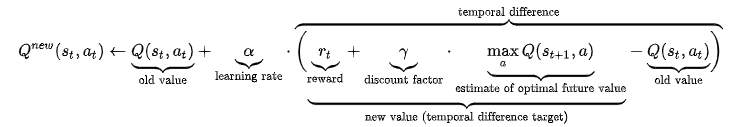

The learning rate, or step size alpha,  determines to what extent newly acquired information overrides old information. A factor of 0 makes the agent learn nothing, while a factor of 1 makes the agent consider only the most recent information. The discount factor gamma determines the importance of future rewards. A factor of 0 will make the agent "myopic" (or short-sighted) by only considering current rewards, while a factor approaching 1 will make it strive for a long-term high reward. If the discount factor meets or exceeds 1, the action values may diverge.

We repeat the above iteration until a terminal state-action pair in the q-table has been reached. The overall algorithm of Q-learning is summarized in the picture below:

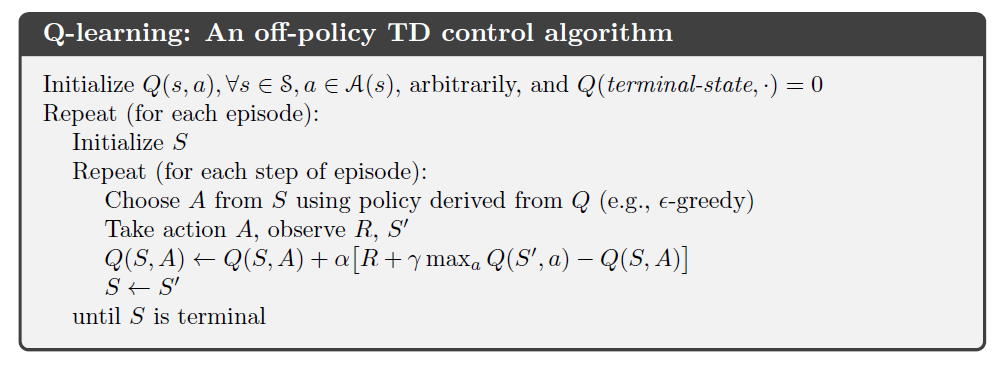

#4. Major Functions and Visualization

Following section includes 2 algorithms written in python, which has been explained above: policy iteration and Q-learning.

To start the algorithms, the states, actions, and discount factor gamma have been declared as follows:

In [ ]:
states = list(range(101))
actions = list(range(101))
nS = len(states) # Number of States
nA = len(actions) # Number of Actions
gamma = 0.95 # discount factor

Then, transition probability and reward were converted to matrix form for selected action:

In [ ]:
def pp_matrix(a):
  matrix = np.empty((nS, nA))
  for i in states:
    for j in states:
      matrix[i,j] = proba(i,j,a)
  return matrix

In [ ]:
reward = np.empty((nS, nS))
for s in states:
  for a in states:
    reward[s,a] = r(s,a)

## **a. Policy Iteration**

In policy iteration, there are 3 key steps:
*   step 1: initialize random policy π(s)

> In this step, initial policy has been set to zeros for all states. 

> In addition, pi_check is initialized as a np.array which contains all zeros. In the later step, the pi_check will be updated and used as a condition for the while loop.

*   step 2: policy evaluation

> V_pi_s will be updated in this stage based on the initial policy.

> val is the reward function calculated using the given policy. 

> V_pi_s has been initialized as a 101x101 matrix with 0s. With the bellman's equation, the V can be calculated as the the inverse of the sum of V_pi_s for all 101 states. 

*   step 3: policy improvement

> Policy π will be updated based on the V_pi_s obtained in the previous step. 

> The policy π is the argmax of V_pi_s.

> If the new policy = old policy, the pi_check matrix will return True, the sum of the pi_check matrix is 101 when new policy = old policy for all states. 

Repeat Step 2 and Step 3 until it converges, which means the iteration will end when the new policy is indentical to the old policy. 





In [ ]:
# initialization
policy = [0 for s in states]

# boolean to check if old pi = new pi
pi_check = np.zeros(nS) 

iterations = 0

# if new pi and old pi are identical, sum(pi_check) = 101 
while sum(pi_check) < 101:
    iterations += 1
    # print('Iteration ',iterations)
     
    # initial V as a matrix to store the entire V
    V = np.zeros((nS, nS))
    val = [0 for s in states] 

    # Policy Evaluation
    for s in states:
      # calculate V[s] with initial policy 
      # val = V0 -> with initalized policy
      val[s] = reward[s,policy[s]]
      # V of entire state 
      V[s] = - gamma * pp_matrix(policy[s])[s]
      V[s,s]+=1
    # Compute the V_new 
    V_new = np.linalg.inv(V).dot(val)

    # Policy improvement
    new_policy = np.zeros(nS)
    for s in states:
      # finding the argmax with the new V
      new_policy[s] = np.argmax([r(s,a) + gamma * sum([pp(s,s1,a)*V_new[s1] for s1 in states]) for a in actions])
      # pi Check 
      if policy[s] == new_policy[s]:
        pi_check[s] = (policy[s] == new_policy[s])
    policy = new_policy.astype(int) # policy (actions) data type need to be int

policy_df = pd.DataFrame({'optimal_s_a': policy, 'V': V_new}) # policy table

### Visualization - Policy Iteration

Below is a plot combined of action vs. states (blue) and V vs. states (orange). It is easier to show the relationship between the V and actions in scatter plot. 

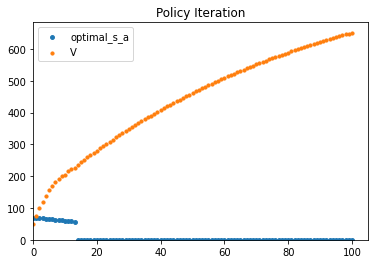

In [ ]:
plt.scatter(policy_df.index, policy_df.optimal_s_a, marker='o', s = 15, label = 'optimal_s_a')
plt.scatter(policy_df.index, policy_df.V, s = 10, label = 'V')
plt.title('Policy Iteration')
plt.legend()
plt.ylim(0,)
plt.xlim(0,)
plt.show()

As the figure above shows, as the state increases, the V value increases. There is a discrete at s = 13, which means that after this state, the actions are all equal to zero.  

However, there are many infeasible solutions after state 13 and these states will not be considered while finding the optimal solution. In these states, actions = 0, even though the value of V shows an increasing trend, it is not possible to find the optimal policy from these states. Thus, the focus of finding the optimal solution will stays in the states with action larger than 0, which is in state 0 to state 13. 

Focusing on the states with action larger than 0, the optimal (s, S) policy is (13,70), and the optimal policy can be found below: 

In [ ]:
visible = policy_df[policy_df.optimal_s_a !=0].reset_index()
print('With the Policy Iteration Method, the optimal (s,S) policy is : ({},{})'.format(max(visible.index), max(visible.optimal_s_a)))
print('optimal policy:')
print(policy)

With the Policy Iteration Method, the optimal (s,S) policy is : (13,70)
optimal policy:
[70 69 68 67 66 65 64 63 62 61 60 59 58 57  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]


## **b. Q-Learning**

**1. Q-learning initialization:**

We started off by defining the key parameters of Q-learning, including the total learning episodes, learing rate alpha, maximum steps per episode, eplison for exploration/exploitation trade-off, and the exponential decay rate. 
We used the decay rate as a part of the improved epsilon-greedy method. In this method, the initially sets epsilon will gradually decreases to end over nstep training epoches/episodes. Specifically, at the initial training process, we let the model more freedom to explore with a high probability, and then gradually decrease the epsilon with the decay rate over training episodes. 
As more steps are taken, the training process will focus more on exploitation while it still can explore with a very small probability when the policy is approximately converged.

We also initialized the zero q-value matrix using the number of states and actions as size, which is 101 *101. The learning rate is a number between  and , which can be thought of as how quickly the agent abandons the previous Q-value in the Q-table for a given state-action pair for the new Q-value. In our case, we set the learning rate=0.2. We also define the number of episodes for learning to be 1000, and maximum steps to taken within each episode is 50.

In [ ]:
total_episodes = 1000        # Total episodes
learning_rate = 0.2           # Learning rate
max_steps = 50                # Max steps per episode 

# Exploration parameters
epsilon = 1.0                 # initial Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005             # Exponential decay rate for exploration prob

In [ ]:
Q = np.zeros([nS,nA]) 
def newstate(a,s):
    return np.random.choice(np.arange(0, nS), p = prob_matrix(a)[s])

**2. Q-leaning algorithm**

In Q-leaning, there are 3 key steps for each episode:

*   Step 1: Agent starts in a random state (s):

> At the very begining we randomly initialize a state from [0,100] as our maximum inventory capacity is 100.

*   Step 2: Agent selects action by referencing Q-table with highest value (max) or randomly takes an feasible action, using epsilon greedy algorithm:

> Since we know that all of the Q-values are first initialized to zero, there's no way for the agent to differentiate between them at the starting state of the first episode. Additionally, we know that we need a balance of exploration and exploitation to choose our actions using epsilon greedy algorithm. With this strategy, we define an exploration rate ε that we initially set to 1. This exploration rate is the probability that our agent will explore the environment rather than exploit it. With ε=1, it is 100% certain that the agent will start out by exploring the environment. As the agent learns more about the environment, at the start of each new episode,  will decay by some rate that we set so that the likelihood of exploration becomes less and less probable as the agent learns more and more about the environment. The agent will become “greedy” in terms of exploiting the environment once it has had the opportunity to explore and learn more about it.


>To determine whether the agent will choose exploration or exploitation at each time step, we generate a random number between 0 and 1. If this number is greater than epsilon, then the agent will choose its next action via exploitation, i.e. it will choose the action with the highest Q-value for its current state from the Q-table. Otherwise, its next action will be chosen via exploration, i.e. randomly choosing its action and exploring what happens in the environment. Notice that the randomly chosen action should satisfied our maximum inventory constraint, i.e. the current inventory level plus chosen action should not be greater than 100.

*   Step 3: Update q-values and Q tables:

> The agent take the action (a) and observe the new state(s') and reward (r)

> Q-table is updated based on Bellman Equation：

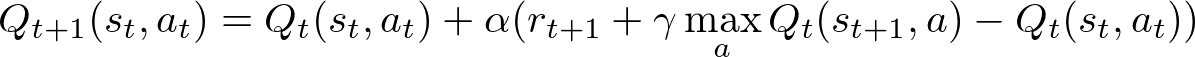

> Average rewards per 50 episodes are calculated and printed below during the training for illustrating whether or not the results converge.




In [ ]:
# List of rewards
rewards = []
# Q learning
for episode in range(total_episodes):
    # Reset the environment
    state = random.randint(0, max_inv) # randomly initialize a state from [0,100] as our maximum inventory capacity is 100
    step = 0
    total_rewards = 0
    
    for step in range(max_steps):
        # Choose an action a in the current state (s) by epsilon greedy algorithm
        # First we randomize a number
        exp_exp_tradeoff = random.uniform(0, 1)
        
        # If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(Q[state,:])

        # Else doing a random choice --> exploration
        else:
            action = random.randint(0, max_inv-state) # the reorder action plus current inventory state should not greater than invenory capacity

        # Take the action (a) and observe the new state(s') and reward (r)
        new_state = newstate(action,state)
        # demand=state+action-new_state
        reward = r(state,action)

        # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
        # qtable[new_state,:] : all the actions we can take from new state
        Q[state, action] = Q[state, action] + learning_rate * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])
        
        total_rewards += reward
        
        # Our new state is state
        state = new_state

        
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
    rewards.append(total_rewards)
# Calculate and print the average reward per 50 episodes
rewards_per_fifty_epi=np.split(np.array(rewards),total_episodes/50)
count=50
print("***************Average reward per 50 episodes****************\n")
for r in rewards_per_fifty_epi:
  print(count,":",str(sum(r/50)))
  count+=50
print ("Score over time: " +  str(sum(rewards)/total_episodes))
print("***************The updated Q table ****************\n")
print(Q)

***************Average reward per 50 episodes****************

50 : -2734.5253146853147
100 : -2012.0125174825173
150 : -1332.5124475524474
200 : -773.5633566433563
250 : -293.918111888112
300 : -107.34167832167829
350 : 98.75895104895109
400 : 304.08559440559446
450 : 549.6160839160839
500 : 652.3079720279721
550 : 676.3641958041959
600 : 772.002027972028
650 : 800.1041958041958
700 : 763.0864335664337
750 : 802.1377622377622
800 : 881.136853146853
850 : 816.3024475524472
900 : 862.374755244755
950 : 780.9867832167831
1000 : 831.6639160839161
Score over time: 116.85272727272735
***************The updated Q table ****************

[[-44.5515     -35.8        -36.6        ... -39.95801062 -88.05663485
  -39.64145307]
 [-10.64405594 -54.44217699 -32.24405594 ...   0.         -23.59682105
    0.        ]
 [ -6.74265734 -27.54265734 -28.34265734 ...   0.           0.
    0.        ]
 ...
 [588.36371013 197.03481159 226.1439355  ...   0.           0.
    0.        ]
 [580.36437623 272.64472

3. Find optimal policy

We arrange the final q-table to obtain the optimal actions given state and their correponding Q-values. To obtain the optimal (s,S) policy, we will find the state and its optimal action under the maximum Q-value in the table. 

In [ ]:
optimal_action = []
optimal_q = []
for i in range(nS):
    optimal_q.append(Q[i,np.argmax(Q[i])]) #Q value under optimal action given state 
    optimal_action.append(np.argmax(Q[i])) #optimal action given state

In [ ]:
optimal_df = pd.DataFrame()
optimal_df.index.name = 'State'
optimal_df['Optimal Action'] = optimal_action
optimal_df['Q Value'] = optimal_q
optimal_df

,Optimal Action,Q Value
State,,
0,81,-1.797357
1,65,21.794779
2,52,39.436169
3,65,68.535614
4,73,94.879326
...,...,...
96,0,593.936023
97,0,600.142675
98,0,588.363710


In [ ]:
non_zero = optimal_df[optimal_df['Optimal Action'] !=0]
non_zero = non_zero.reset_index()
optimal_s = non_zero.74-6[non_zero['Q Value'].argmax(),0]
optimal_S = non_zero.iloc[non_zero['Q Value'].argmax(),1]+optimal_s
print('The optimal (s,S) policy found using Q learning algorithm is : ({},{})'.format(optimal_s, optimal_S))

The optimal (s,S) policy found using Q learning algorithm is : (6,74)


**Conclustion: the optimal policy(s,S) is (6,74)**

###Visualization - Q-Learning

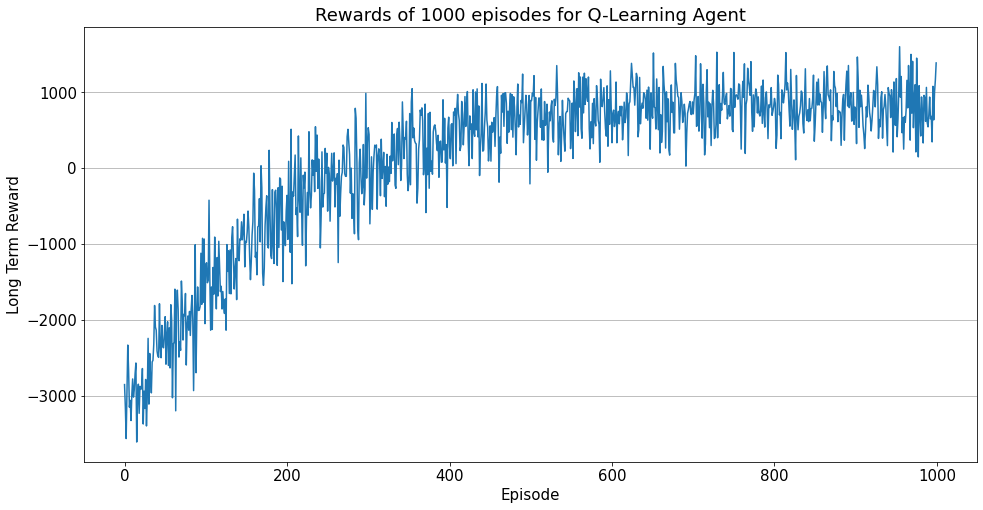

In [ ]:
#visualization of rewards
plt.figure(figsize=(16,8))
plt.rc('font', size=15) 


plt.title("Rewards of 1000 episodes for Q-Learning Agent")
plt.plot(np.arange(len(rewards)), rewards)
plt.grid(axis='y')
plt.xlabel('Episode')
plt.ylabel('Long Term Reward')
plt.show()

From the plot, we can see that the long-term rewards converge after 600 episodes, fluctuating around 800 ~1000. We are able to achieve the convergence with positive reward in the long term, which suggests the Q-learning is an algorithm that works for our problem. The fluctuation is quite consistent, but the overall converging trend played a major role in the long term from the graph.

We also want to simulate the inventory levels for different states. For simplicity, assume that there's no demands in the weekends. Instead of working with uniformly distributed weekly demand [0,10], we are now working with uniformly distributed daily demand at [0,2], and we simulate the inventory change for 400 days with random starting inventory using our optimal (s,S) policy obtained from the Q-learning algorithm, which is (6,74).

In [ ]:
# assume no demand during weekends as the stores are closed
# From weekly demand follows discrete uniform [0,10]
# so, demand for every weekday follows discrete uniform [0,2]
# we generate demands for 200 periods (400 days)
demand=[]
for i in range(200):
  d=random.randint(0, 2)
  demand.append(d)
len(demand)


200

In [ ]:
tttt=np.zeros(5)
tt=np.array([0,10])
tt[1]

10

In [ ]:
(14+1)%5==0 and 3%5==0

False

In [ ]:
# stimulate the inventory overtime under our optimal (s,S) policy
def simulation(state, s, S):
  inv=np.zeros(200)
  inv[0]=state
  for i in range(1,200):
    reorder=0
    inv[i]=inv[i]+inv[i-1]-demand[i]
    if (i+1)%5 == 0 and inv[i]<=s and (i+5)<=200:
      reorder=S-inv[i]
      inv[i+5]=reorder
  return inv


In [ ]:
inv=random.randint(0, 100) #given starting inventory level by randomly choosing integer from [0,100]
inv_over_time=simulation(inv, optimal_s, optimal_S) 
print("starting inventory is {}, and the inventory level over time are {}".format(inv, inv_over_time) )

starting inventory is 45, and the inventory level over time are [45. 43. 43. 43. 41. 41. 40. 40. 38. 37. 37. 36. 35. 34. 33. 31. 30. 28.
 27. 25. 24. 23. 23. 23. 22. 20. 19. 18. 18. 17. 17. 17. 17. 16. 16. 15.
 14. 12. 12. 12. 12. 10.  8.  6.  4.  2.  2.  2.  1. 70. 68. 67. 66. 65.
 63. 61. 61. 61. 61. 61. 60. 59. 59. 58. 57. 56. 55. 54. 53. 51. 49. 48.
 48. 48. 47. 47. 45. 44. 44. 44. 43. 42. 40. 39. 38. 37. 35. 33. 32. 31.
 30. 30. 30. 29. 28. 27. 25. 23. 23. 22. 22. 20. 19. 18. 16. 15. 13. 12.
 11. 11.  9.  8.  8.  8.  6.  6.  6.  6.  5. 73. 71. 69. 69. 69. 67. 65.
 64. 62. 61. 59. 58. 56. 54. 53. 52. 52. 50. 50. 48. 48. 46. 46. 44. 42.
 41. 41. 41. 40. 38. 36. 36. 36. 34. 32. 31. 29. 29. 29. 28. 27. 25. 25.
 24. 22. 21. 19. 17. 15. 14. 14. 12. 10. 10.  9.  8.  7.  7.  5.  4.  2.
  0. -2. -4. -4. 67. 66. 64. 64. 62. 61. 59. 59. 58. 57. 56. 56. 54. 52.
 51. 51.]


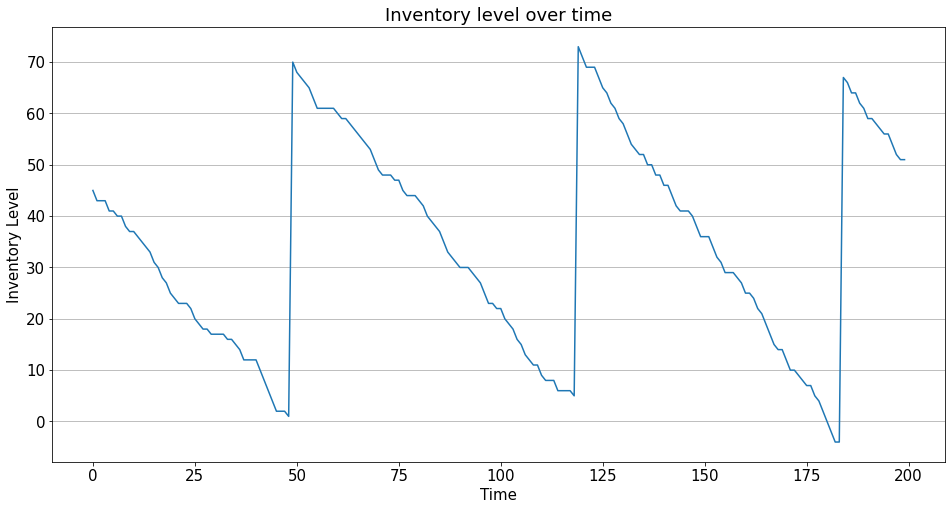

In [ ]:
plt.figure(figsize=(16,8))
plt.rc('font', size=15) 
plt.title("Inventory level over time")
plt.plot(inv_over_time)
plt.grid(axis='y')
plt.xlabel('Time')
plt.ylabel('Inventory Level')
plt.show()

For this simulation, we started the inventory at 45, and by observing the inventory level over time above, we can notice that there's a restock happening roughly every 50 period/100 days. The maximum inventory is 73 around the 150th period, while the lowest inventory was below 0 around the 180th period. The stockout happened for 3 days during the later stage of the simulation, but we are able to recover by quickly restocking. 

More simulations under the optimal policy obtained from Q-learning: i.e. with initial inventory 28, 60 and 92 to see how will the inventory level change over 200 periods. 

In [ ]:
inv1=random.randint(0, 100) #given starting inventory level by randomly choosing integer from [0,100]
inv_over_time1=simulation(inv1, optimal_s, optimal_S) 
print("starting inventory is {}, and the inventory level over time are {}".format(inv1, inv_over_time1) )

starting inventory is 60, and the inventory level over time are [60. 58. 58. 58. 56. 56. 55. 55. 53. 52. 52. 51. 50. 49. 48. 46. 45. 43.
 42. 40. 39. 38. 38. 38. 37. 35. 34. 33. 33. 32. 32. 32. 32. 31. 31. 30.
 29. 27. 27. 27. 27. 25. 23. 21. 19. 17. 17. 17. 16. 15. 13. 12. 11. 10.
  8.  6.  6.  6.  6.  6.  5.  4.  4.  3. 70. 69. 68. 67. 66. 64. 62. 61.
 61. 61. 60. 60. 58. 57. 57. 57. 56. 55. 53. 52. 51. 50. 48. 46. 45. 44.
 43. 43. 43. 42. 41. 40. 38. 36. 36. 35. 35. 33. 32. 31. 29. 28. 26. 25.
 24. 24. 22. 21. 21. 21. 19. 19. 19. 19. 18. 18. 16. 14. 14. 14. 12. 10.
  9.  7.  6.  4.  3.  1. -1. -2. 67. 67. 65. 65. 63. 63. 61. 61. 59. 57.
 56. 56. 56. 55. 53. 51. 51. 51. 49. 47. 46. 44. 44. 44. 43. 42. 40. 40.
 39. 37. 36. 34. 32. 30. 29. 29. 27. 25. 25. 24. 23. 22. 22. 20. 19. 17.
 15. 13. 11. 11. 10.  9.  7.  7.  5.  4.  2.  2.  1.  0. 69. 69. 67. 65.
 64. 64.]


In [ ]:
inv2=random.randint(0, 100) #given starting inventory level by randomly choosing integer from [0,100]
inv_over_time2=simulation(inv2, optimal_s, optimal_S) 
print("starting inventory is {}, and the inventory level over time are {}".format(inv2, inv_over_time2) )

starting inventory is 92, and the inventory level over time are [92. 90. 90. 90. 88. 88. 87. 87. 85. 84. 84. 83. 82. 81. 80. 78. 77. 75.
 74. 72. 71. 70. 70. 70. 69. 67. 66. 65. 65. 64. 64. 64. 64. 63. 63. 62.
 61. 59. 59. 59. 59. 57. 55. 53. 51. 49. 49. 49. 48. 47. 45. 44. 43. 42.
 40. 38. 38. 38. 38. 38. 37. 36. 36. 35. 34. 33. 32. 31. 30. 28. 26. 25.
 25. 25. 24. 24. 22. 21. 21. 21. 20. 19. 17. 16. 15. 14. 12. 10.  9.  8.
  7.  7.  7.  6.  5.  4.  2.  0.  0. 68. 68. 66. 65. 64. 62. 61. 59. 58.
 57. 57. 55. 54. 54. 54. 52. 52. 52. 52. 51. 51. 49. 47. 47. 47. 45. 43.
 42. 40. 39. 37. 36. 34. 32. 31. 30. 30. 28. 28. 26. 26. 24. 24. 22. 20.
 19. 19. 19. 18. 16. 14. 14. 14. 12. 10.  9.  7.  7.  7.  6.  5.  3.  3.
  2.  0. 68. 66. 64. 62. 61. 61. 59. 57. 57. 56. 55. 54. 54. 52. 51. 49.
 47. 45. 43. 43. 42. 41. 39. 39. 37. 36. 34. 34. 33. 32. 31. 31. 29. 27.
 26. 26.]


In [ ]:
inv3=random.randint(0, 100) #given starting inventory level by randomly choosing integer from [0,100]
inv_over_time3=simulation(inv3, optimal_s, optimal_S) 
print("starting inventory is {}, and the inventory level over time are {}".format(inv3, inv_over_time3) )

starting inventory is 28, and the inventory level over time are [28. 26. 26. 26. 24. 24. 23. 23. 21. 20. 20. 19. 18. 17. 16. 14. 13. 11.
 10.  8.  7.  6.  6.  6.  5.  3.  2.  1.  1. 69. 69. 69. 69. 68. 68. 67.
 66. 64. 64. 64. 64. 62. 60. 58. 56. 54. 54. 54. 53. 52. 50. 49. 48. 47.
 45. 43. 43. 43. 43. 43. 42. 41. 41. 40. 39. 38. 37. 36. 35. 33. 31. 30.
 30. 30. 29. 29. 27. 26. 26. 26. 25. 24. 22. 21. 20. 19. 17. 15. 14. 13.
 12. 12. 12. 11. 10.  9.  7.  5.  5.  4.  4.  2.  1.  0. 68. 67. 65. 64.
 63. 63. 61. 60. 60. 60. 58. 58. 58. 58. 57. 57. 55. 53. 53. 53. 51. 49.
 48. 46. 45. 43. 42. 40. 38. 37. 36. 36. 34. 34. 32. 32. 30. 30. 28. 26.
 25. 25. 25. 24. 22. 20. 20. 20. 18. 16. 15. 13. 13. 13. 12. 11.  9.  9.
  8.  6.  5.  3.  1. -1. -2. 67. 65. 63. 63. 62. 61. 60. 60. 58. 57. 55.
 53. 51. 49. 49. 48. 47. 45. 45. 43. 42. 40. 40. 39. 38. 37. 37. 35. 33.
 32. 32.]


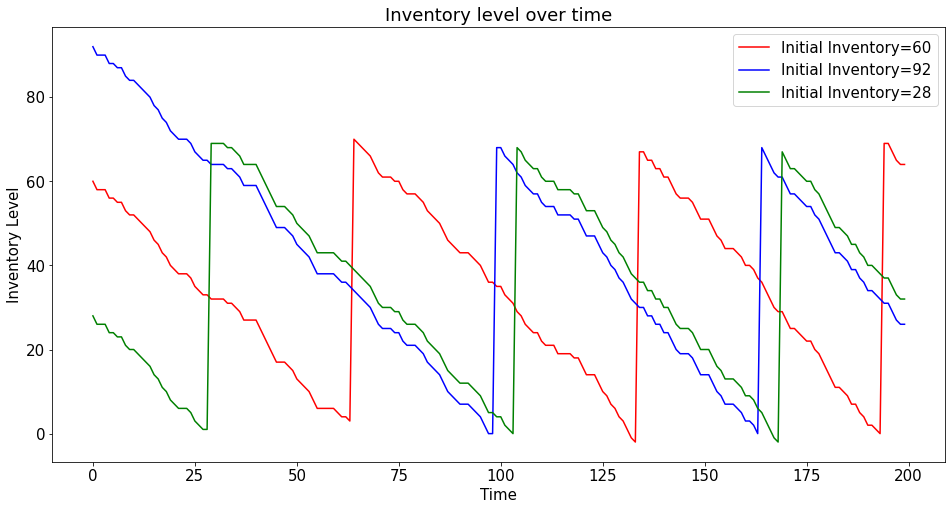

In [ ]:
plt.figure(figsize=(16,8))
plt.rc('font', size=15) 
plt.title("Inventory level over time")
plt.xlabel('Time')
plt.ylabel('Inventory Level')
plt.plot(np.arange(len(inv_over_time1)),inv_over_time1,color='r',label='Initial Inventory=60')
plt.plot(np.arange(len(inv_over_time1)),inv_over_time2,color='b',label='Initial Inventory=92')
plt.plot(np.arange(len(inv_over_time3)),inv_over_time3,color='g',label='Initial Inventory=28');
plt.legend()
plt.show()

For this simulation, the restock period is roughly 60 - 70  for all initial inventory levels in the long term, and it's also noticable that it took around 100 period before the first restock when the initial inventory is 92, while it took only 25 period when the initial inventory is 28. The maximum inventory was kept around 70. We did experience a brief stock-out for 2 days with initial inventory being 28 and 60 during the later stage of the simulation, but no stock-out was observed for initial inventory = 92, which suggests that we could use high starting inventory to leverage the potential stock-out possibilities later. 

#5. Lessons Learned

This project solves the Markov decision process through two methods: policy iteration and Q-learning. Policy iteration improves the process by repeating the policy evaluation and policy improvement steps in each iteration until convergence is reached. It is a model based algorithm to find the optimal policy by the given action and state. On the other hand, Q-learning is a model free algorithm contains three key steps to obtain the optimal policy. The results from both methods are fairly close to each other in terms of S, and Q-learning resulted in a smaller number in states than policy iteration's state. 

#6. References

https://www0.gsb.columbia.edu/mygsb/faculty/research/pubfiles/4030/federgruen_finding.pdf

https://www.geeksforgeeks.org/markov-decision-process/

https://towardsdatascience.com/policy-iteration-in-rl-an-illustration-6d58bdcb87a7

https://www.baeldung.com/cs/ml-value-iteration-vs-policy-iteration

http://incompleteideas.net/book/ebook/node43.html
 
https://deeplizard.com/learn/video/mo96Nqlo1L8
